<a href="https://colab.research.google.com/github/bbachonko/regression-models/blob/main/Flight_price_predict_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight price prediction

We willl preprocess data, visualize some of them and then fit into couple classifiers using simple pipeline.

In [3]:
import numpy as np
import pandas as pd
import datetime as datetime
import seaborn as sns
import plotly 
from collections import deque

Fristlly let's make a copy of raw data to have a deafult looking dataset in case we need it. Then see at the first few rows od dataframe.

In [4]:
df_train_raw = pd.read_excel('Data_Train.xlsx')
df_test_raw = pd.read_excel('Test_set.xlsx')

df = df_train_raw.copy()

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


It is worth to mention the **dataset is initally separated into train and split one.**


Wee can notice most of columns are probably of categorical type. See if it's true.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


As I wrote we have only one column - *price* which is a numeric type. We will probably need to change their types into numeric ones.
Now check number of missing rows for each column.

In [6]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

We have only 2 Nan's in each data set. We can drop them with a clear conscience.

In [7]:
df = df.dropna()

# Kaggle Questions

Let's firstly answer to questioned marked on the kaggle site. They will help us analyze which columns may have an impact on flight prices.

**Does price vary with Airlines?**


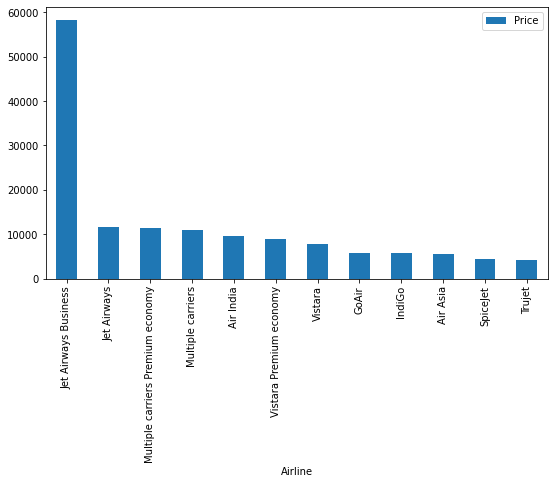

In [8]:

prices_by_airline = df.groupby('Airline')['Price'].mean().reset_index().sort_values('Price', ascending=False)
prices_by_airline.plot(kind='bar', x='Airline', y='Price', figsize=(9,5))

As shown, mean price for one of line is costs significantly more than for the rest. However on a barplot we can't see the numbers of flights and its dsitribution. 
We can use other kind of plot.

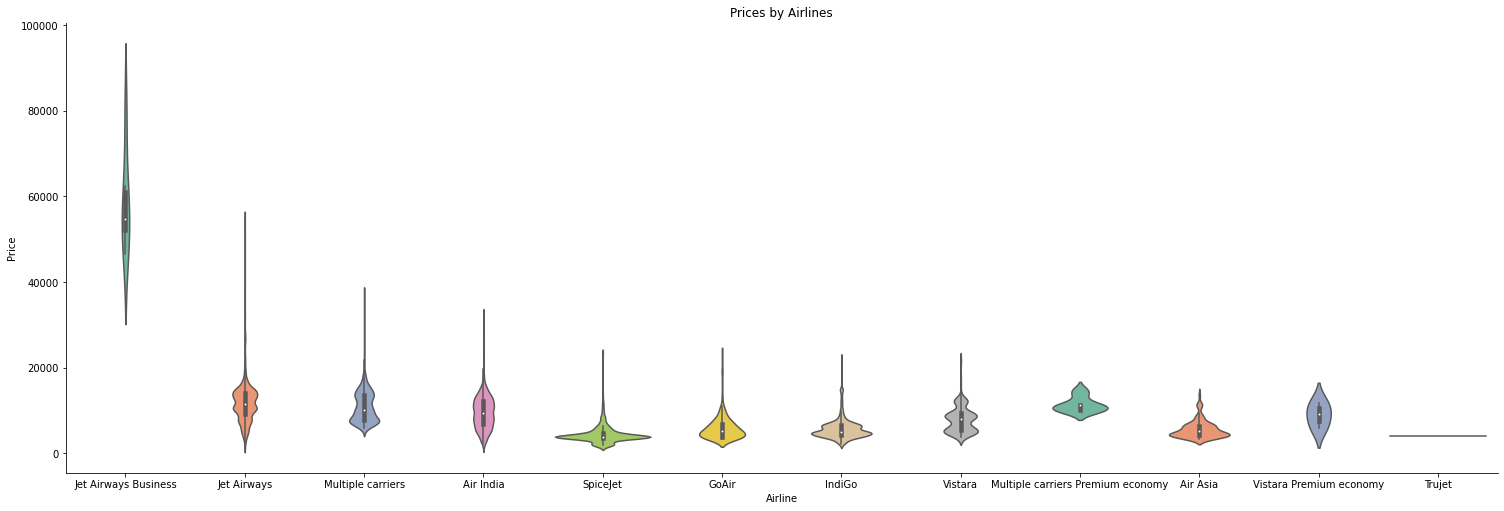

In [9]:
sns.catplot(y = "Price", x = "Airline", data = df.sort_values("Price", ascending = False), kind="violin", height = 7, aspect = 3, palette='Set2').set(title='Prices by Airlines')

Here we can see how the price of flights varies depending on which airline it is and how it is distributed on a *Price* axis.  


**Does ticket price change based on the departure time and arrival time?**

We notcied that the *Dep_Time* column is object type so change it to string and slice into only hour intersections to enable making a clear categorical plot

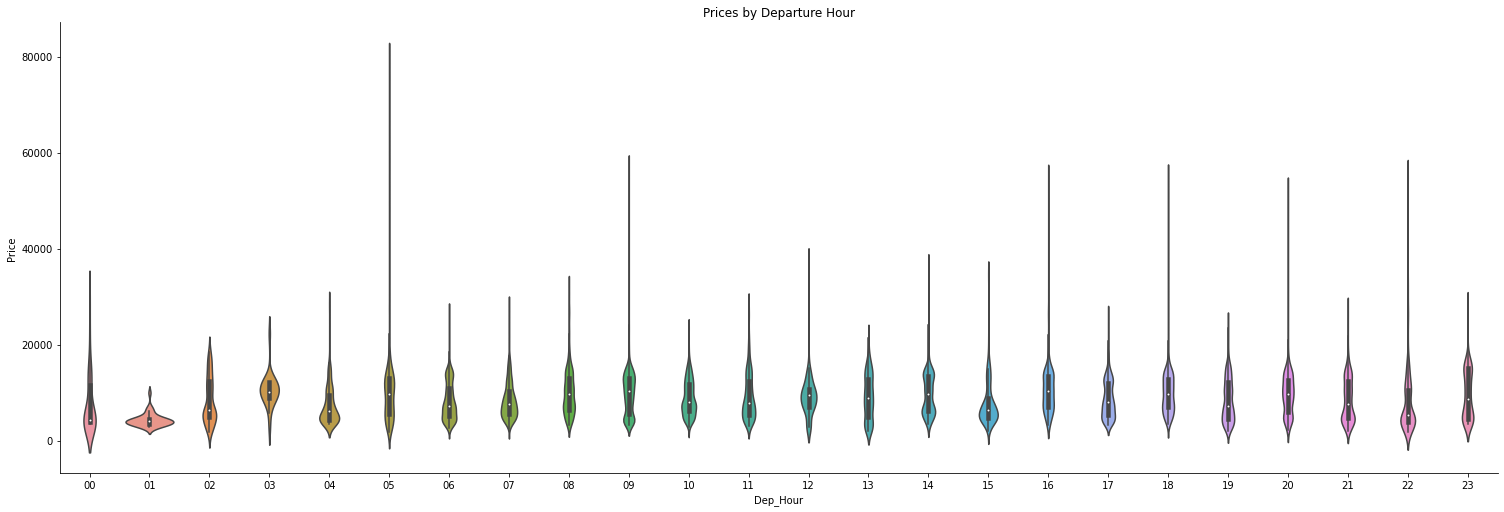

In [10]:
df['Dep_Time'] = df['Dep_Time'].astype(str)
df['Dep_Hour'] = df['Dep_Time'].str[:2]


sns.catplot(y = "Price", x = "Dep_Hour", data = df.sort_values("Dep_Hour"), kind="violin", height = 7, aspect = 3).set(title='Prices by Departure Hour')

The bigger part of prices on each hour is located at the similar level. 

I'll do the same with *Arrival_Time* column.

In [11]:
df['Arrival_Time'] = df['Arrival_Time'].astype(str)
df['Arr_Hour'] = df['Arrival_Time'].str[:2]

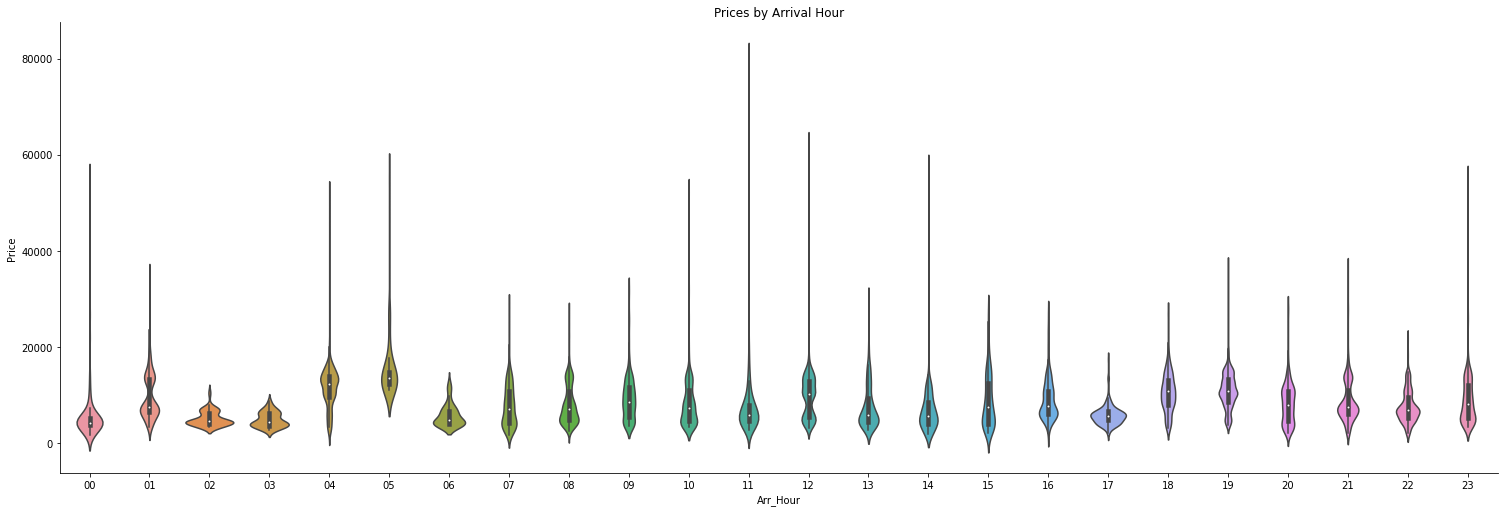

In [12]:
sns.catplot(y = "Price", x = "Arr_Hour", data = df.sort_values("Arr_Hour"), kind="violin", height = 7, aspect = 3).set(title='Prices by Arrival Hour')

No unique things can be noticed here. It can be said the time of arrival or departure does not have a big impact on flight prices.

**How the price changes with change in Source and Destination?**

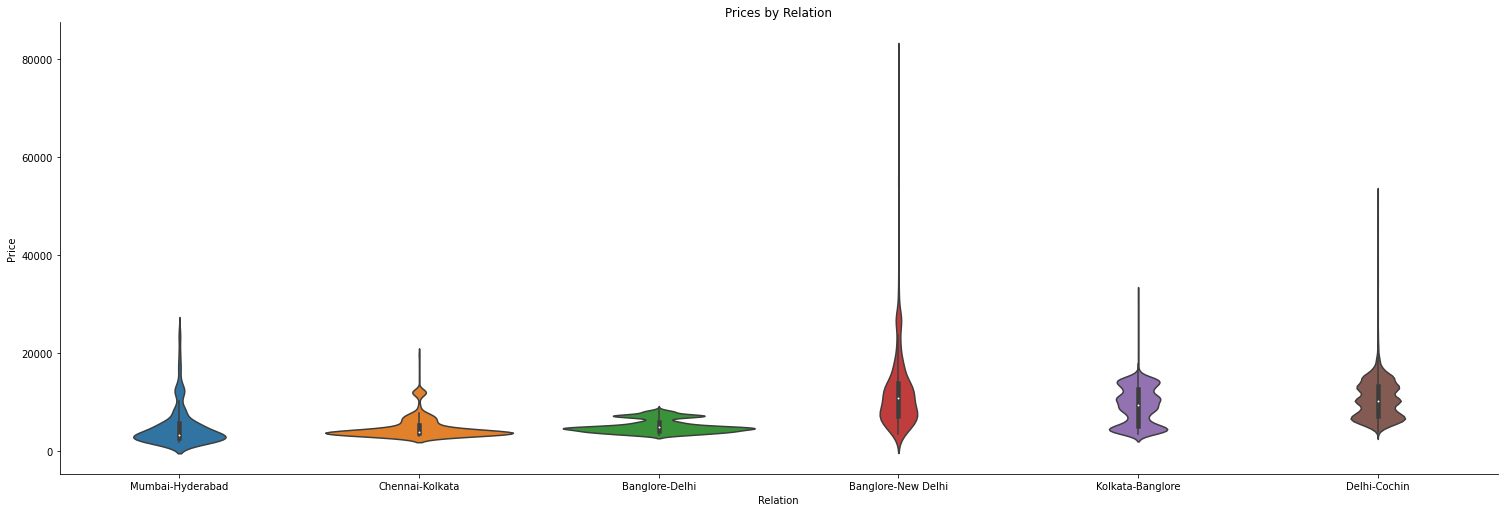

In [13]:
df['Relation'] = df[['Source', 'Destination']].agg('-'.join, axis=1)

sns.catplot(y="Price", x="Relation", data=df.sort_values("Price"), kind="violin", height=7, aspect=3).set(title='Prices by Relation')

Prices by relation (aggregated as in two sites) are distributed on constant intervals, so we don't have significant differences between them. 
We can suppose the more densly marked areas are the effect of volatility in demand on tickets and the just oscilates between some points for most of time.

**Now we need to do something with non-numeric data columns in dataset. Most of regression models can't pass it through.**

See at the dataframe again. Starting from *Additional_Info*

In [14]:
df['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

We have 2 columns with the same intended name. 

In [15]:
df.Additional_Info = df.Additional_Info.apply(lambda x: 'No info' if x == 'No Info' else x)

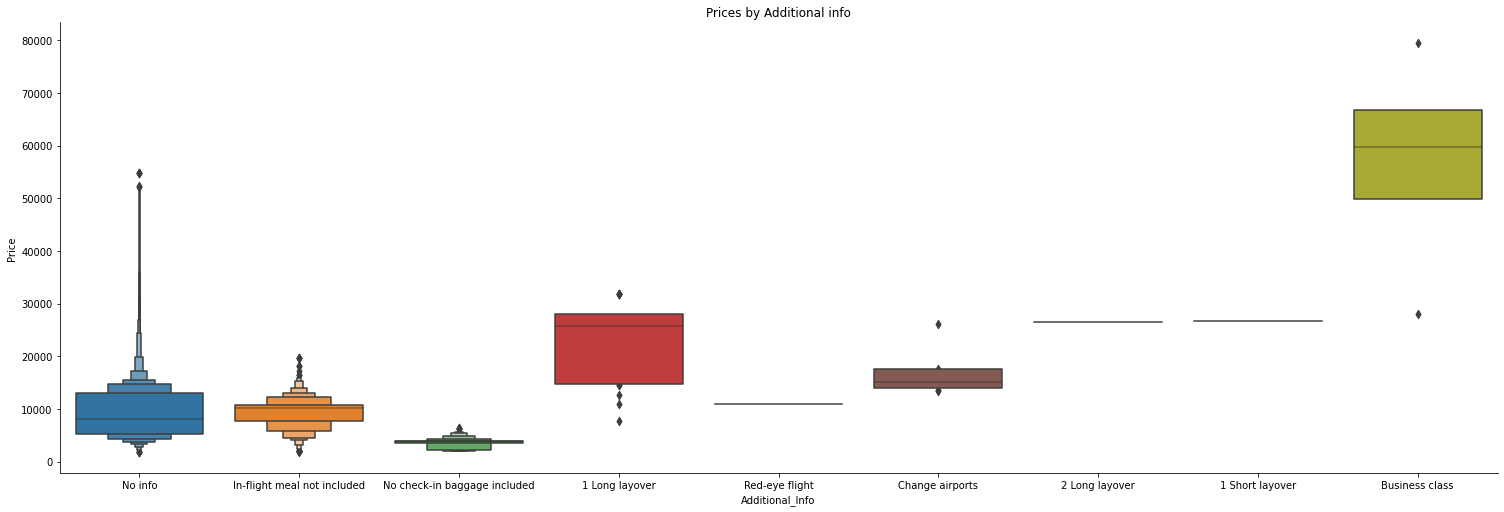

In [16]:
sns.catplot(y="Price", x="Additional_Info", data=df.sort_values("Price"), kind="boxen", height=7, aspect=3).set(title='Prices by Additional info')

Some special options for flight as *Layover* may have a significant influence on its price. However we have only few of rows with so typed information.

We can look at datatime-similar columns and make the more friendly for fitting the right model

In [17]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Hour,Arr_Hour,Relation
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,22,01,Banglore-New Delhi
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,05,13,Kolkata-Banglore
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,09,04,Delhi-Cochin
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,18,23,Kolkata-Banglore
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,16,21,Banglore-New Delhi


In [18]:
from pandas.core.series import Series

df['Date_of_Journey'] = df['Date_of_Journey'].astype('datetime64')
df[['Dep_Hour', 'Arr_Hour']] = df[['Dep_Hour', 'Arr_Hour']] .astype(int)

# deleting 'Route' beacuse we have info about stops in other columns, as well as Dep_Time and Arival_Time - we extract hour from them in previeus steps
df = df.drop(columns=['Route', 'Dep_Time', 'Arrival_Time'], axis=1)


#Extracting duration time from column
def duration_col_format(row):
  # (_h) format
  if len(row) == 2:
    row = row[0]
  # (__h) and (__h __m) format
  elif len(row) > 2:
    row = row[:2]
  row = row.replace('h', '')
  return row

df.Duration = df.Duration.apply(duration_col_format)

# Mapping the integer values depends on stops number
df.Total_Stops.replace({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}, inplace=True)

I will extract month and day from Journey dat column.

In [19]:
df['Month_of_Journey'] = df['Date_of_Journey'].dt.month
df['Day_of_Journey'] = df['Date_of_Journey'].dt.day

And now we have unnecesary additional column which we can drop.

In [20]:
df = df.drop(columns=['Date_of_Journey'], axis=1)

Before the actual fittiing our data set to any classifier look at how it looks now.

In [50]:
df.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,Dep_Hour,Arr_Hour,Relation,Month_of_Journey,Day_of_Journey
0,IndiGo,Banglore,New Delhi,2,0,No info,3897,22,1,Banglore-New Delhi,3,24
1,Air India,Kolkata,Banglore,7,2,No info,7662,5,13,Kolkata-Banglore,1,5
2,Jet Airways,Delhi,Cochin,19,2,No info,13882,9,4,Delhi-Cochin,9,6
3,IndiGo,Kolkata,Banglore,5,1,No info,6218,18,23,Kolkata-Banglore,12,5
4,IndiGo,Banglore,New Delhi,4,1,No info,13302,16,21,Banglore-New Delhi,1,3


# Importing necessary modules and data preparation



In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import *
import numpy as np

# Regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


classifiers = [LinearRegression(), RandomForestRegressor(), Ridge(), DecisionTreeRegressor(), Lasso(tol=.01)]
#classifier_names = [for model in classifiers: model=type(model).__name__]

#creating a list of models basing on selected classifiers
classifier_names = []
for model in classifiers: classifier_names.append (type(model).__name__)

zipped_clf = zip(classifier_names, classifiers)

Pulling out from data set first 1300 rows should be enough tot train a good model and makes calculations faster. 

Splitting into train and test part to test the classifier on other rows.

In [52]:
from sklearn.model_selection import train_test_split

df_shortened = df[:1300]

y = df_shortened['Price']
df_shortened = df_shortened.drop(columns=['Price'], axis=1)
x = df_shortened


x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85)



print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (1105, 11)
Shape of y_train: (1105,)
Shape of x_test: (195, 11)
Shape of y_test: (195,)


# Fitting dataframe into classifiers

Defining preprocessors methods for categorical columns

In [53]:
#definng pipeline with preprocessors for our simple pipeline
#from sklearn.compose import ColumnTransformer

transformer = Pipeline(steps=[
                          
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))])                         

In [54]:
from sklearn.model_selection import KFold

def fit_classifier(pipeline, x_train, y_train, params=None):
  
    model_fit = pipeline.fit(x, y)
    cv = KFold(n_splits=10)
    mean_scores = cross_val_score(pipeline, x, y, cv=cv, scoring='r2', fit_params=params).mean()
  
    return mean_scores

In [55]:
def classifier(classifier, x, y):
    result = []
    for name, cl in classifier:
      # inserting into default pipeline yet-defined preprocessors and individual classifiers
        checker_pipeline = Pipeline([
            ('n', transformer),                         
            ('classifier', cl)
        ])
      
        clf_acc = fit_classifier(checker_pipeline, x_train, y_train)
        result.append((name, clf_acc))

    return result

result = classifier(zipped_clf, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29701105.086437225, tolerance: 23250986.79765812
  positive,


In [56]:
acc = {}

for i in range(len(result)):
    
    print('\nalgorithm = ', result[i][0], '\nr2 score =', result[i][1])


algorithm =  LinearRegression 
r2 score = 0.6885567342602366

algorithm =  RandomForestRegressor 
r2 score = 0.7990017120791224

algorithm =  Ridge 
r2 score = 0.689229436696739

algorithm =  DecisionTreeRegressor 
r2 score = 0.7016840259269224

algorithm =  Lasso 
r2 score = 0.6894316709104436


**Our top score is ~0.8 (RandomForestRegressor), wich is not bad considering we didn't tune any hyperparameters of any model.**

# Applying hyperparameter tuning

We can serach for optimal parameters for the best scoring classifier.
I will use 

In [57]:
from sklearn.utils.extmath import weighted_mode
from sklearn import pipeline
from sklearn.model_selection import RandomizedSearchCV

transformer = Pipeline(steps=[
                      ('encoder', OneHotEncoder(handle_unknown='ignore')),
                      ('scaler', StandardScaler(with_mean=False))])


def randomized_search_fit(transf, x, y):
  pipeline = Pipeline([
            ('n', transf),                         
            ('clf', RandomForestRegressor()),
     ])
  
  random_grid = {
                'clf__n_estimators': [50, 100, 500, 700, 1000],
                'clf__max_features': ['auto', 'sqrt'],
                'clf__max_depth': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                'clf__min_samples_split': [5, 10, 15, 20, 30],
                'clf__min_samples_leaf': [1, 2, 4],
                'clf__bootstrap': [True, False]
              }

  rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=random_grid, n_iter=10, cv=7, n_jobs=-1, verbose=3, scoring='r2')
  rf_random.fit(x_train, y_train)
  result = rf_random.best_score_, rf_random.best_params_

  return result


rf = RandomForestRegressor()

randomized_search_fit(transformer, x_train, y_train)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


(0.7685041360078342,
 {'clf__bootstrap': True,
  'clf__max_depth': 70,
  'clf__max_features': 'auto',
  'clf__min_samples_leaf': 2,
  'clf__min_samples_split': 5,
  'clf__n_estimators': 1000})

Now as a last step just load the test paramaters to abouve function to see how it works.

In [59]:
test_result = randomized_search_fit(transformer, x_test, y_test)
test_result

Fitting 7 folds for each of 10 candidates, totalling 70 fits


(0.7394477098127369,
 {'clf__bootstrap': False,
  'clf__max_depth': 50,
  'clf__max_features': 'sqrt',
  'clf__min_samples_leaf': 2,
  'clf__min_samples_split': 15,
  'clf__n_estimators': 700})

The result turned out to be a bit worse, however the difference is acceptable. Anyway the cclassifier **is not overfitted** to the train data set.

# Summary

As we can see although fitting into the chosen classifier non-default parameters (best ones according to *RandomizedSearchCV*) we obtained a worse metric. 

---



The reason of that may be e.g. not enough number of tried parameters - computations for these ones exceed a couple of minutes.

The other reason why we got a bit worse score  may be way of preprocessing dataset we insert into model. We could've done in a bit other way for example extract more features from some columns.